TL;DR:
 * Training diverges around epoch 798

In [2]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: serene-terrain-99
MODEL_NAME = "20220621-072935_11_tacotron_8khz_5secs_3000_epochs_256_batch_lamb__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [3]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [4]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/11_tacotron_8khz_5secs_3000_epochs_256_batch_lamb.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')
frames_per_step = gin.query_parameter('%frames_per_step')
mel_bins = gin.query_parameter('%mel_bins')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

2022-06-21 15:16:31.973202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-21 15:16:31.973599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [5]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

2022-06-21 15:16:33.330403: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


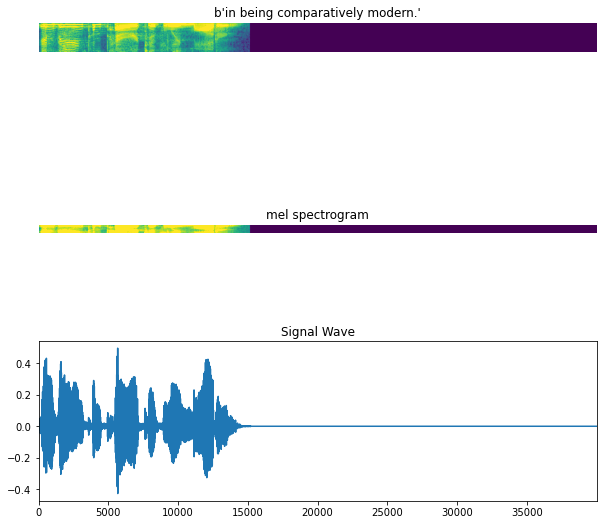

In [6]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [7]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
res = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [40]:
tts_100 = models.TacotronTTS()
tts_100.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_100')

tts_600 = models.TacotronTTS()
tts_600.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_600')

tts_700 = models.TacotronTTS()
tts_700.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_700')

# model after first epoch
tts_0 = models.TacotronTTS()
tts_0.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_0')

In [28]:
GEN_FRAMES = 600

def summarize_mel_stats(mel_spec, new_mel_spec):
    ref_spec = mel_spec[:GEN_FRAMES,:].flatten()
    pred_spec = new_mel_spec[0].numpy().flatten()
    print(f'L1 {np.abs(pred_spec - ref_spec).mean()}')
    return pd.DataFrame({
        'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(),
        'predicted_mel_spec': new_mel_spec[0].numpy().flatten()
    }).describe()

def mel_spec_viz(mel_spec, extra_title=''):
    ax = plt.subplot(2, 1, 1)
    ax.imshow(np.transpose(mel_spec[0]), vmax=1)
    ax.set_title('predicted mel spectrogram' + extra_title)
    ax.axis("off")

    ax = plt.subplot(2, 1, 2)
    ax.imshow(np.transpose(mel_spec[0]))
    ax.set_title('predicted mel spectrogram normalized' + extra_title)
    ax.axis("off")
    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    mask = input != tf.constant(-1, dtype=tf.int64)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)
    conv_bank = tts.tacotron_encoder.cbhg.conv_bank(pre_net)
    pooling = tts.tacotron_encoder.cbhg.pooling(conv_bank)
    conv_proj1 = tts.tacotron_encoder.cbhg.conv_proj1(pooling)
    conv_proj2 = tts.tacotron_encoder.cbhg.conv_proj2(conv_proj1)
    pre_highway = pre_net + conv_proj2
    highway = tts.tacotron_encoder.cbhg.highway(pre_highway)
    rnn = tts.tacotron_encoder.cbhg.rnn_encoder(highway, mask=mask)

    plt.figure(figsize=(14, 8))
    
    data_sets = [
        encoded, embed, pre_net, conv_bank, pooling,
        conv_proj1, conv_proj2, pre_highway, highway, rnn
    ]
    captions = [
        'encoded', 'embedded', 'pre_net', 'conv_bank', 'pooling',
        'conv_proj1', 'conv_proj2', 'pre_highway', 'highway', 'rnn'
    ]
    
    for ix, (caption, data) in enumerate(zip(captions, data_sets)):
        ax = plt.subplot(1, len(data_sets), ix+1)
        ax.imshow(np.transpose(data[0]))
        ax.set_title(caption)
        ax.axis("off")
        
    plt.show()

In [41]:
# Generate mel_specs

input = tf.expand_dims(enc_transcription[enc_transcription!=-1], 0)
new_mel_spec_700, new_spec_700 = tts_700.decode(input, GEN_FRAMES // frames_per_step)
new_mel_spec_600, new_spec_600 = tts_600.decode(input, GEN_FRAMES // frames_per_step)
new_mel_spec_100, new_spec_100 = tts_100.decode(input, GEN_FRAMES // frames_per_step)
new_mel_spec_0, new_spec_0 = tts_0.decode(input, GEN_FRAMES // frames_per_step)

In [42]:
tf.shape(new_mel_spec_700), tf.shape(new_spec_700)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([  1, 600,  20], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([  1, 600,  65], dtype=int32)>)

In [43]:
summarize_mel_stats(mel_spec, new_mel_spec_700)

L1 0.3081229627132416


,mel_spec,predicted_mel_spec
count,12000.000000,12000.000000
mean,0.734959,0.983688
std,0.411534,0.065969
min,0.000000,0.611804
25%,0.599281,0.937498
50%,0.892328,0.986670
75%,1.024878,1.026492
max,1.286578,1.198159


In [44]:
summarize_mel_stats(mel_spec, new_mel_spec_600)

L1 0.3159228563308716


,mel_spec,predicted_mel_spec
count,12000.000000,12000.000000
mean,0.734959,0.985447
std,0.411534,0.088208
min,0.000000,0.605329
25%,0.599281,0.928426
50%,0.892328,0.971029
75%,1.024878,1.036452
max,1.286578,1.311993


In [45]:
summarize_mel_stats(mel_spec, new_mel_spec_100)

L1 0.3070460557937622


,mel_spec,predicted_mel_spec
count,12000.000000,12000.000000
mean,0.734959,0.793624
std,0.411534,0.095220
min,0.000000,0.437762
25%,0.599281,0.721885
50%,0.892328,0.784860
75%,1.024878,0.860501
max,1.286578,1.098978


In [46]:
summarize_mel_stats(mel_spec, new_mel_spec_0)

L1 0.7335606813430786


,mel_spec,predicted_mel_spec
count,12000.000000,12000.000000
mean,0.734959,0.002466
std,0.411534,0.004122
min,0.000000,0.000000
25%,0.599281,0.000000
50%,0.892328,0.000000
75%,1.024878,0.003673
max,1.286578,0.017354


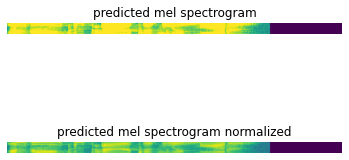

In [33]:
mel_spec_viz([mel_spec[:GEN_FRAMES,:]])

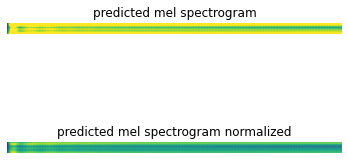

In [34]:
mel_spec_viz(new_mel_spec_700)

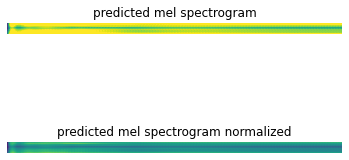

In [35]:
mel_spec_viz(new_mel_spec_600)

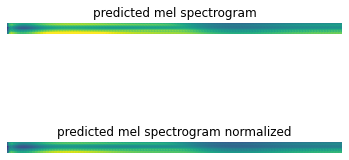

In [47]:
mel_spec_viz(new_mel_spec_100)

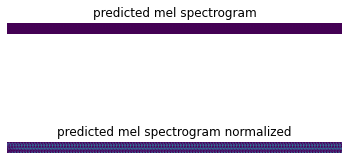

In [36]:
mel_spec_viz(new_mel_spec_0)

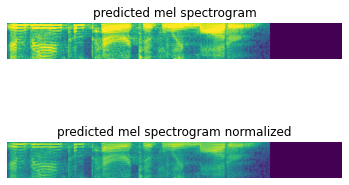

In [37]:
mel_spec_viz([spectrogram[:GEN_FRAMES]])

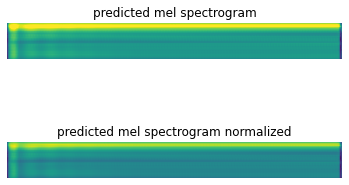

In [38]:
mel_spec_viz(new_spec_700)

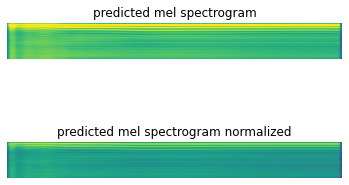

In [39]:
mel_spec_viz(new_spec_600)

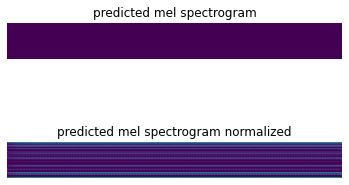

In [24]:
mel_spec_viz(new_spec_0)

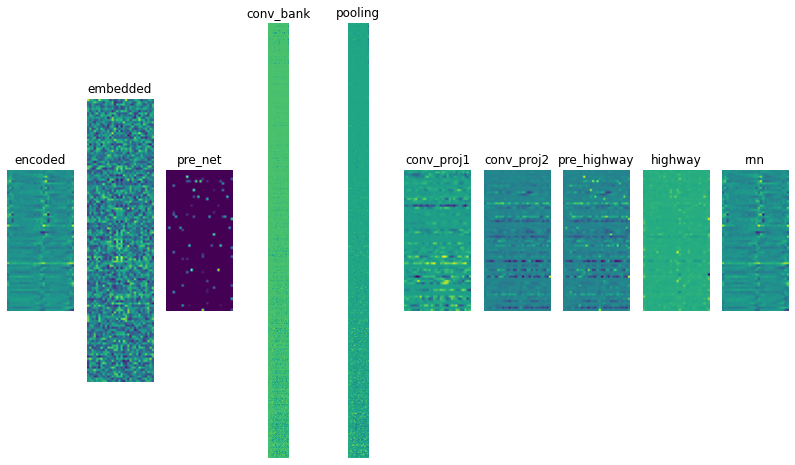

In [25]:
encoder_viz(tts_700, input)

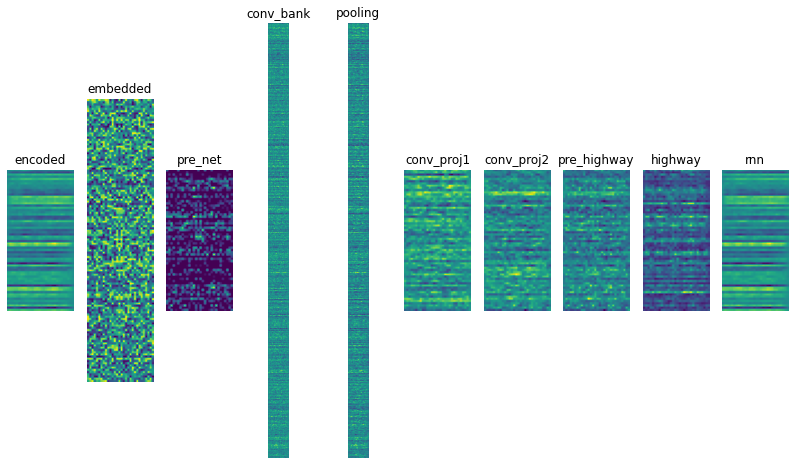

In [26]:
encoder_viz(tts_0, input)

In [48]:
def visualize_attention_states(attention):
    cell_states, attention, alignments = attention

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(cell_states[:,:]))
    ax.set_title('cell states')
    ax.axis("off")
    plt.show()
    
    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(attention[:,:]))
    ax.set_title('attention')
    ax.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 14))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(alignments[:,:]))
    ax.set_title('attention state (alignments)')
    ax.axis("off")
    plt.show()

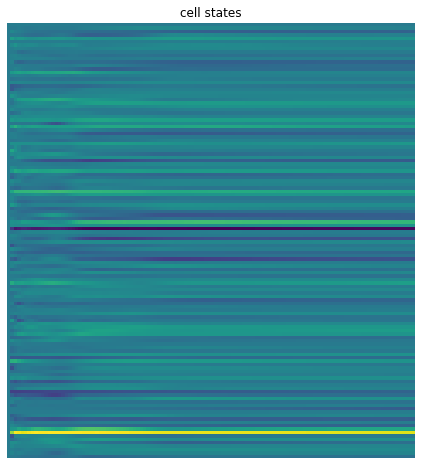

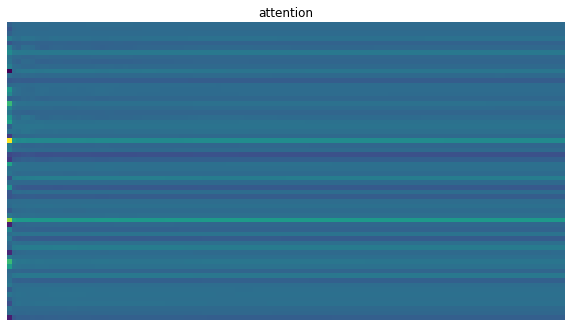

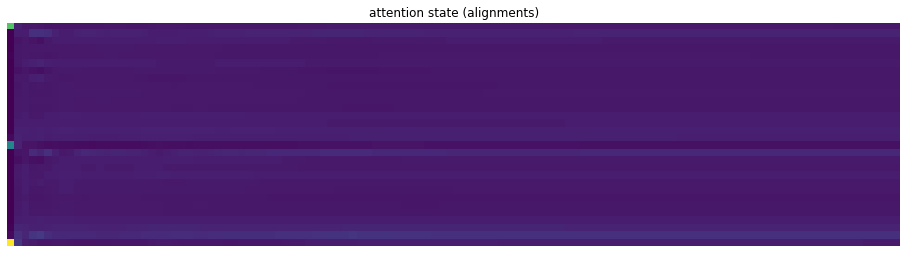

In [53]:
# TRAINED TTS
_, attention = tts_600.decode(input, GEN_FRAMES // frames_per_step, return_attention=True)
visualize_attention_states(attention)

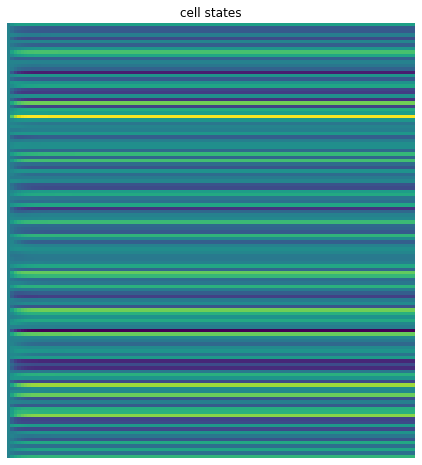

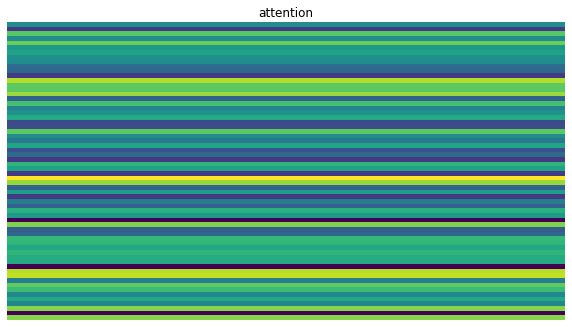

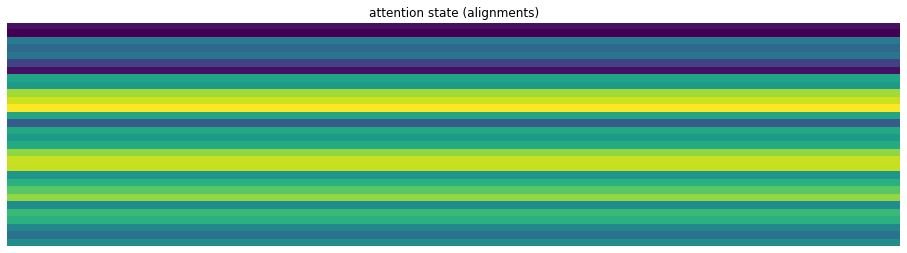

In [54]:
# TRAINED TTS epoch 0
_, attention = tts_0.decode(input, GEN_FRAMES // frames_per_step, return_attention=True)
visualize_attention_states(attention)